# Traffic Ligth Detection
Welcome to the traffic light detection! This notebook explains step-by-step how to train and use traffic light detection models for the [Udacity Self-Driving Car Engineer Capstone Project](https://github.com/barrykidney/CarND-Capstone). Make sure you meet all preconditions before you start, see README.md.

# Imports

In [10]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
from PIL import Image

## Env setup

In [18]:
# This is needed to display the images.
%matplotlib inline


# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
sys.path.append("../slim")

## Object detection imports
Here are the imports from the object detection module.

In [19]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Define the dataset and the pretrained model to be used. 

To train or test images from the simulator set `DATASET=sim` for real world images (Carla) set `DATASET=real`

Change `MODEL` and `MODEL_VERSION` if you want to use other pretrained models, see the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [20]:
# choose model
MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'
PIPELINE_CONFING_FILENAME = 'ssd_mobilenet_v2.config'

# ****************** don't edit from here ******************

# What model to download.
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PRETRAIND_MODELS_DIR = 'models'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT =  os.path.join(PRETRAIND_MODELS_DIR, MODEL, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('config', 'labels_map.pbtxt')

PIPELINE_CONFING_FILEPATH = os.path.join('config', PIPELINE_CONFING_FILENAME)

CHECKPOIONTS_DIR = 'checkpoints/' + MODEL
FINETUNED_MODEL_DIR = 'fine_tuned_models/' + MODEL
FINETUNED_MODEL = os.path.join(FINETUNED_MODEL_DIR, 'frozen_inference_graph.pb')

NUM_CLASSES = 3

# Train Traffic Light Detection Model

**NOTE:** If you have already trained the model, you can skip the training- and export steps and proceed directly with testing...

## Download Pretrained Model
**NOTE:** This step only needs to be done once if the pretrained model has not been downloaded yet!

In [11]:
MODEL_ZIP = os.path.join(PRETRAIND_MODELS_DIR, MODEL_FILE)
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_ZIP)
tar_file = tarfile.open(MODEL_ZIP)
tar_file.extractall(os.path.join(os.getcwd(), PRETRAIND_MODELS_DIR))
tar_file.close()    

## Train Finetuned Model

Starts the training. This step may take several hours, depending on the computing power of your computer. 

You can monitor the training process using tensorboard `tensorboard --logdir=%CHECKPOIONTS_DIR%` and stop the training if once the desired accuracy has been achieved.

In [5]:
# python train.py --pipeline_config_path=%PIPELINE_CONFING_FILEPATH% --train_dir=%CHECKPOIONTS_DIR% 

import functools
import json
import trainer

from builders import model_builder
from builders import input_reader_builder
from protos import train_pb2
from protos import pipeline_pb2
from google.protobuf import text_format

train_dir = CHECKPOIONTS_DIR
pipeline_config_path = PIPELINE_CONFING_FILEPATH

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.gfile.GFile(pipeline_config_path, 'r') as f:
    text_format.Merge(f.read(), pipeline_config)

model_config = pipeline_config.model
train_config = pipeline_config.train_config
input_config = pipeline_config.train_input_reader

model_fn = functools.partial(model_builder.build, model_config=model_config, is_training=True)

create_input_dict_fn = functools.partial(input_reader_builder.build, input_config)

env = json.loads(os.environ.get('TF_CONFIG', '{}'))
cluster_data = env.get('cluster', None)
cluster = tf.train.ClusterSpec(cluster_data) if cluster_data else None
task_data = env.get('task', None) or {'type': 'master', 'index': 0}
task_info = type('TaskSpec', (object,), task_data)

# Parameters for a single worker.
ps_tasks = 0
worker_replicas = 1
worker_job_name = 'lonely_worker'
task = 0
is_chief = True
master = ''
num_clones = 1
clone_on_cpu = False

trainer.train(create_input_dict_fn, model_fn, train_config, master, task,
                num_clones, worker_replicas, clone_on_cpu, ps_tasks,
                worker_job_name, is_chief, train_dir)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `

INFO:tensorflow:global step 5015: loss = 1.9182 (1.128 sec/step)
INFO:tensorflow:global step 5016: loss = 2.0629 (1.122 sec/step)
INFO:tensorflow:global step 5017: loss = 1.9020 (1.115 sec/step)
INFO:tensorflow:global step 5018: loss = 2.0711 (1.154 sec/step)
INFO:tensorflow:global step 5019: loss = 1.8158 (1.128 sec/step)
INFO:tensorflow:global step 5020: loss = 2.0800 (1.159 sec/step)
INFO:tensorflow:global step 5021: loss = 2.0176 (1.136 sec/step)
INFO:tensorflow:global step 5022: loss = 2.0015 (1.139 sec/step)
INFO:tensorflow:global step 5023: loss = 1.7717 (1.141 sec/step)
INFO:tensorflow:global step 5024: loss = 2.0852 (1.150 sec/step)
INFO:tensorflow:global step 5025: loss = 2.1630 (1.151 sec/step)
INFO:tensorflow:global step 5026: loss = 2.3575 (1.094 sec/step)
INFO:tensorflow:global step 5027: loss = 1.9533 (1.144 sec/step)
INFO:tensorflow:global step 5028: loss = 2.1309 (1.112 sec/step)
INFO:tensorflow:global step 5029: loss = 2.0656 (1.117 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5140: loss = 1.9872 (1.144 sec/step)
INFO:tensorflow:global step 5141: loss = 2.1998 (1.259 sec/step)
INFO:tensorflow:global step 5142: loss = 1.8211 (1.277 sec/step)
INFO:tensorflow:global step 5143: loss = 2.4955 (1.158 sec/step)
INFO:tensorflow:global step 5144: loss = 1.9561 (1.193 sec/step)
INFO:tensorflow:global step 5145: loss = 2.0538 (1.155 sec/step)
INFO:tensorflow:global step 5146: loss = 2.0966 (1.241 sec/step)
INFO:tensorflow:global step 5147: loss = 1.9577 (1.215 sec/step)
INFO:tensorflow:global step 5148: loss = 1.8265 (1.175 sec/step)
INFO:tensorflow:global step 5149: loss = 1.8730 (1.124 sec/step)
INFO:tensorflow:global step 5150: loss = 1.9937 (1.144 sec/step)
INFO:tensorflow:global step 5151: loss = 1.9221 (1.132 sec/step)
INFO:tensorflow:global step 5152: loss = 1.9136 (1.160 sec/step)
INFO:tensorflow:global step 5153: loss = 2.0233 (1.145 sec/step)
INFO:tensorflow:global step 5154: loss = 2.0926 (1.196 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5265: loss = 1.9469 (1.114 sec/step)
INFO:tensorflow:global step 5266: loss = 2.4074 (1.109 sec/step)
INFO:tensorflow:global step 5267: loss = 2.1637 (1.192 sec/step)
INFO:tensorflow:global step 5268: loss = 2.4494 (1.125 sec/step)
INFO:tensorflow:global step 5269: loss = 2.0101 (1.164 sec/step)
INFO:tensorflow:global step 5270: loss = 1.7324 (1.109 sec/step)
INFO:tensorflow:global step 5271: loss = 2.0542 (1.305 sec/step)
INFO:tensorflow:global step 5272: loss = 2.0196 (1.182 sec/step)
INFO:tensorflow:global step 5273: loss = 2.3139 (1.184 sec/step)
INFO:tensorflow:global step 5274: loss = 2.4549 (1.216 sec/step)
INFO:tensorflow:global step 5275: loss = 1.9110 (1.191 sec/step)
INFO:tensorflow:global step 5276: loss = 1.8805 (1.157 sec/step)
INFO:tensorflow:global step 5277: loss = 2.4377 (1.161 sec/step)
INFO:tensorflow:global step 5278: loss = 2.1701 (1.161 sec/step)
INFO:tensorflow:global step 5279: loss = 2.2224 (1.151 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5389: loss = 2.1086 (1.110 sec/step)
INFO:tensorflow:global step 5390: loss = 2.5121 (1.135 sec/step)
INFO:tensorflow:global step 5391: loss = 2.1588 (1.156 sec/step)
INFO:tensorflow:global step 5392: loss = 1.9455 (1.130 sec/step)
INFO:tensorflow:global step 5393: loss = 1.9248 (1.132 sec/step)
INFO:tensorflow:global_step/sec: 0.874687
INFO:tensorflow:global step 5394: loss = 1.8059 (1.160 sec/step)
INFO:tensorflow:global step 5395: loss = 2.3771 (1.119 sec/step)
INFO:tensorflow:global step 5396: loss = 1.9717 (1.132 sec/step)
INFO:tensorflow:global step 5397: loss = 2.0470 (1.147 sec/step)
INFO:tensorflow:global step 5398: loss = 1.8734 (1.113 sec/step)
INFO:tensorflow:global step 5399: loss = 2.0814 (1.146 sec/step)
INFO:tensorflow:global step 5400: loss = 1.8354 (1.140 sec/step)
INFO:tensorflow:global step 5401: loss = 1.9645 (1.130 sec/step)
INFO:tensorflow:global step 5402: loss = 1.7418 (1.104 sec/step)
INFO:tensorflow:global step 5403: loss = 1.9861 

INFO:tensorflow:global step 5507: loss = 2.0449 (1.178 sec/step)
INFO:tensorflow:global step 5508: loss = 2.0155 (1.235 sec/step)
INFO:tensorflow:global step 5509: loss = 2.1016 (1.206 sec/step)
INFO:tensorflow:global step 5510: loss = 2.2179 (1.146 sec/step)
INFO:tensorflow:global step 5511: loss = 2.3130 (1.143 sec/step)
INFO:tensorflow:global step 5512: loss = 1.9106 (1.142 sec/step)
INFO:tensorflow:global step 5513: loss = 2.2214 (1.133 sec/step)
INFO:tensorflow:global step 5514: loss = 1.8389 (1.156 sec/step)
INFO:tensorflow:global step 5515: loss = 2.1433 (1.137 sec/step)
INFO:tensorflow:global step 5516: loss = 1.7858 (1.147 sec/step)
INFO:tensorflow:global step 5517: loss = 2.2482 (1.129 sec/step)
INFO:tensorflow:global step 5518: loss = 2.0766 (1.157 sec/step)
INFO:tensorflow:global step 5519: loss = 2.7371 (1.186 sec/step)
INFO:tensorflow:global step 5520: loss = 1.7433 (1.162 sec/step)
INFO:tensorflow:global step 5521: loss = 2.6133 (1.144 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5632: loss = 2.0456 (1.130 sec/step)
INFO:tensorflow:global step 5633: loss = 2.9052 (1.094 sec/step)
INFO:tensorflow:global step 5634: loss = 2.1884 (1.121 sec/step)
INFO:tensorflow:global step 5635: loss = 2.0536 (1.108 sec/step)
INFO:tensorflow:global step 5636: loss = 1.8820 (1.107 sec/step)
INFO:tensorflow:global step 5637: loss = 1.9552 (1.116 sec/step)
INFO:tensorflow:global step 5638: loss = 2.1911 (1.115 sec/step)
INFO:tensorflow:global step 5639: loss = 1.9348 (1.184 sec/step)
INFO:tensorflow:global step 5640: loss = 2.2487 (1.146 sec/step)
INFO:tensorflow:global step 5641: loss = 2.4868 (1.126 sec/step)
INFO:tensorflow:global step 5642: loss = 1.9865 (1.127 sec/step)
INFO:tensorflow:global step 5643: loss = 1.9266 (1.112 sec/step)
INFO:tensorflow:global step 5644: loss = 2.3321 (1.117 sec/step)
INFO:tensorflow:global step 5645: loss = 2.1769 (1.131 sec/step)
INFO:tensorflow:global step 5646: loss = 1.9215 (1.133 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5757: loss = 1.9333 (1.109 sec/step)
INFO:tensorflow:global step 5758: loss = 2.1890 (1.127 sec/step)
INFO:tensorflow:global step 5759: loss = 1.8473 (1.103 sec/step)
INFO:tensorflow:global step 5760: loss = 2.6985 (1.107 sec/step)
INFO:tensorflow:global step 5761: loss = 2.3539 (1.128 sec/step)
INFO:tensorflow:global step 5762: loss = 2.1384 (1.094 sec/step)
INFO:tensorflow:global step 5763: loss = 1.9572 (1.196 sec/step)
INFO:tensorflow:global step 5764: loss = 2.3068 (1.172 sec/step)
INFO:tensorflow:global step 5765: loss = 2.0993 (1.188 sec/step)
INFO:tensorflow:global step 5766: loss = 1.8854 (1.098 sec/step)
INFO:tensorflow:global step 5767: loss = 1.7533 (1.116 sec/step)
INFO:tensorflow:global step 5768: loss = 2.2462 (1.114 sec/step)
INFO:tensorflow:global step 5769: loss = 2.2619 (1.113 sec/step)
INFO:tensorflow:global step 5770: loss = 2.0879 (1.110 sec/step)
INFO:tensorflow:global step 5771: loss = 2.4269 (1.114 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5882: loss = 1.9635 (1.129 sec/step)
INFO:tensorflow:global step 5883: loss = 2.0503 (1.121 sec/step)
INFO:tensorflow:global step 5884: loss = 1.9477 (1.123 sec/step)
INFO:tensorflow:global step 5885: loss = 2.0020 (1.087 sec/step)
INFO:tensorflow:global step 5886: loss = 1.8859 (1.110 sec/step)
INFO:tensorflow:global step 5887: loss = 2.3698 (1.128 sec/step)
INFO:tensorflow:global step 5888: loss = 1.8707 (1.105 sec/step)
INFO:tensorflow:global step 5889: loss = 2.3087 (1.118 sec/step)
INFO:tensorflow:global step 5890: loss = 1.7249 (1.120 sec/step)
INFO:tensorflow:global step 5891: loss = 2.1479 (1.127 sec/step)
INFO:tensorflow:global step 5892: loss = 2.0892 (1.090 sec/step)
INFO:tensorflow:global step 5893: loss = 1.8059 (1.112 sec/step)
INFO:tensorflow:global step 5894: loss = 1.8541 (1.087 sec/step)
INFO:tensorflow:global step 5895: loss = 2.2690 (1.117 sec/step)
INFO:tensorflow:global step 5896: loss = 1.9008 (1.103 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6007: loss = 1.8561 (1.124 sec/step)
INFO:tensorflow:global step 6008: loss = 2.1361 (1.145 sec/step)
INFO:tensorflow:global step 6009: loss = 2.0390 (1.132 sec/step)
INFO:tensorflow:global step 6010: loss = 1.8959 (1.121 sec/step)
INFO:tensorflow:global step 6011: loss = 2.1508 (1.146 sec/step)
INFO:tensorflow:global step 6012: loss = 1.6720 (1.125 sec/step)
INFO:tensorflow:global step 6013: loss = 1.7081 (1.131 sec/step)
INFO:tensorflow:global step 6014: loss = 2.0134 (1.118 sec/step)
INFO:tensorflow:global step 6015: loss = 1.9043 (1.107 sec/step)
INFO:tensorflow:global step 6016: loss = 2.1313 (1.137 sec/step)
INFO:tensorflow:global step 6017: loss = 2.1048 (1.099 sec/step)
INFO:tensorflow:global step 6018: loss = 2.2186 (1.104 sec/step)
INFO:tensorflow:Saving checkpoint to path checkpoints/sim_ssd_inception_v2_coco_2018_01_28\model.ckpt
INFO:tensorflow:global step 6019: loss = 2.1977 (1.241 sec/step)
INFO:tensorflow:Recording summary at step 6019.
INFO:

INFO:tensorflow:global step 6130: loss = 1.8943 (1.143 sec/step)
INFO:tensorflow:global step 6131: loss = 2.2612 (1.123 sec/step)
INFO:tensorflow:global step 6132: loss = 2.3667 (1.150 sec/step)
INFO:tensorflow:global step 6133: loss = 2.0728 (1.120 sec/step)
INFO:tensorflow:global step 6134: loss = 1.9105 (1.110 sec/step)
INFO:tensorflow:global step 6135: loss = 1.8142 (1.117 sec/step)
INFO:tensorflow:global step 6136: loss = 2.0890 (1.117 sec/step)
INFO:tensorflow:global step 6137: loss = 1.7428 (1.112 sec/step)
INFO:tensorflow:global step 6138: loss = 2.6713 (1.107 sec/step)
INFO:tensorflow:global step 6139: loss = 2.4159 (1.174 sec/step)
INFO:tensorflow:global step 6140: loss = 2.0650 (1.113 sec/step)
INFO:tensorflow:global step 6141: loss = 2.1521 (1.151 sec/step)
INFO:tensorflow:global step 6142: loss = 1.9989 (1.209 sec/step)
INFO:tensorflow:global step 6143: loss = 2.2095 (1.138 sec/step)
INFO:tensorflow:global step 6144: loss = 1.9596 (1.121 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6256: loss = 1.9172 (1.113 sec/step)
INFO:tensorflow:global step 6257: loss = 1.7138 (1.132 sec/step)
INFO:tensorflow:global step 6258: loss = 1.9785 (1.175 sec/step)
INFO:tensorflow:global step 6259: loss = 2.1718 (1.107 sec/step)
INFO:tensorflow:global step 6260: loss = 1.9053 (1.124 sec/step)
INFO:tensorflow:global step 6261: loss = 1.8504 (1.121 sec/step)
INFO:tensorflow:global step 6262: loss = 2.1700 (1.121 sec/step)
INFO:tensorflow:global step 6263: loss = 1.9956 (1.130 sec/step)
INFO:tensorflow:global step 6264: loss = 2.2740 (1.109 sec/step)
INFO:tensorflow:global step 6265: loss = 2.6104 (1.121 sec/step)
INFO:tensorflow:global step 6266: loss = 1.9701 (1.107 sec/step)
INFO:tensorflow:global step 6267: loss = 2.7294 (1.124 sec/step)
INFO:tensorflow:global step 6268: loss = 1.8932 (1.112 sec/step)
INFO:tensorflow:global step 6269: loss = 1.9278 (1.132 sec/step)
INFO:tensorflow:global step 6270: loss = 1.8218 (1.119 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6382: loss = 1.6338 (1.113 sec/step)
INFO:tensorflow:global step 6383: loss = 2.1733 (1.134 sec/step)
INFO:tensorflow:global step 6384: loss = 1.7666 (1.129 sec/step)
INFO:tensorflow:global step 6385: loss = 2.2186 (1.103 sec/step)
INFO:tensorflow:global step 6386: loss = 2.5926 (1.103 sec/step)
INFO:tensorflow:global step 6387: loss = 2.0343 (1.117 sec/step)
INFO:tensorflow:global step 6388: loss = 1.9653 (1.122 sec/step)
INFO:tensorflow:global step 6389: loss = 2.3305 (1.127 sec/step)
INFO:tensorflow:global step 6390: loss = 2.0444 (1.119 sec/step)
INFO:tensorflow:global step 6391: loss = 2.2560 (1.103 sec/step)
INFO:tensorflow:global step 6392: loss = 1.9256 (1.115 sec/step)
INFO:tensorflow:global step 6393: loss = 2.4105 (1.115 sec/step)
INFO:tensorflow:global step 6394: loss = 2.3819 (1.122 sec/step)
INFO:tensorflow:global step 6395: loss = 1.9312 (1.097 sec/step)
INFO:tensorflow:global step 6396: loss = 2.2650 (1.130 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6508: loss = 2.1791 (1.096 sec/step)
INFO:tensorflow:global step 6509: loss = 1.8553 (1.115 sec/step)
INFO:tensorflow:global step 6510: loss = 2.3994 (1.132 sec/step)
INFO:tensorflow:global step 6511: loss = 2.3640 (1.127 sec/step)
INFO:tensorflow:global step 6512: loss = 1.8506 (1.115 sec/step)
INFO:tensorflow:global step 6513: loss = 2.1837 (1.193 sec/step)
INFO:tensorflow:global step 6514: loss = 2.1052 (1.117 sec/step)
INFO:tensorflow:global step 6515: loss = 1.9540 (1.113 sec/step)
INFO:tensorflow:global step 6516: loss = 2.3583 (1.122 sec/step)
INFO:tensorflow:global step 6517: loss = 1.9990 (1.111 sec/step)
INFO:tensorflow:global step 6518: loss = 1.9779 (1.102 sec/step)
INFO:tensorflow:global step 6519: loss = 1.9524 (1.111 sec/step)
INFO:tensorflow:global step 6520: loss = 2.3015 (1.115 sec/step)
INFO:tensorflow:global step 6521: loss = 2.1590 (1.126 sec/step)
INFO:tensorflow:global step 6522: loss = 1.8615 (1.137 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6632: loss = 1.8874 (1.137 sec/step)
INFO:tensorflow:global step 6633: loss = 2.0254 (1.142 sec/step)
INFO:tensorflow:global step 6634: loss = 1.9795 (1.111 sec/step)
INFO:tensorflow:global step 6635: loss = 2.0213 (1.110 sec/step)
INFO:tensorflow:global step 6636: loss = 1.7967 (1.141 sec/step)
INFO:tensorflow:global step 6637: loss = 1.9991 (1.110 sec/step)
INFO:tensorflow:global step 6638: loss = 1.9081 (1.116 sec/step)
INFO:tensorflow:global step 6639: loss = 1.9385 (1.128 sec/step)
INFO:tensorflow:global step 6640: loss = 2.2448 (1.129 sec/step)
INFO:tensorflow:global step 6641: loss = 1.7340 (1.104 sec/step)
INFO:tensorflow:global step 6642: loss = 1.7897 (1.129 sec/step)
INFO:tensorflow:global step 6643: loss = 2.5352 (1.116 sec/step)
INFO:tensorflow:global step 6644: loss = 2.6062 (1.133 sec/step)
INFO:tensorflow:global step 6645: loss = 1.8041 (1.196 sec/step)
INFO:tensorflow:global step 6646: loss = 2.0227 (1.128 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6758: loss = 2.1802 (1.126 sec/step)
INFO:tensorflow:global step 6759: loss = 2.1643 (1.115 sec/step)
INFO:tensorflow:Recording summary at step 6760.
INFO:tensorflow:global step 6760: loss = 1.9363 (1.794 sec/step)
INFO:tensorflow:global step 6761: loss = 2.1922 (1.101 sec/step)
INFO:tensorflow:global step 6762: loss = 1.6635 (1.101 sec/step)
INFO:tensorflow:global step 6763: loss = 2.3101 (1.125 sec/step)
INFO:tensorflow:global step 6764: loss = 1.7166 (1.118 sec/step)
INFO:tensorflow:global step 6765: loss = 2.0333 (1.133 sec/step)
INFO:tensorflow:global step 6766: loss = 1.9892 (1.123 sec/step)
INFO:tensorflow:global step 6767: loss = 1.8617 (1.142 sec/step)
INFO:tensorflow:global step 6768: loss = 2.2690 (1.123 sec/step)
INFO:tensorflow:global step 6769: loss = 2.2986 (1.114 sec/step)
INFO:tensorflow:global step 6770: loss = 1.9155 (1.117 sec/step)
INFO:tensorflow:global step 6771: loss = 2.4996 (1.115 sec/step)
INFO:tensorflow:global step 6772: loss = 1

INFO:tensorflow:global step 6883: loss = 2.2754 (1.170 sec/step)
INFO:tensorflow:global step 6884: loss = 1.9818 (1.108 sec/step)
INFO:tensorflow:global step 6885: loss = 2.1060 (1.114 sec/step)
INFO:tensorflow:global step 6886: loss = 1.8860 (1.114 sec/step)
INFO:tensorflow:global step 6887: loss = 1.8387 (1.123 sec/step)
INFO:tensorflow:global step 6888: loss = 1.8312 (1.122 sec/step)
INFO:tensorflow:global step 6889: loss = 1.9431 (1.174 sec/step)
INFO:tensorflow:global step 6890: loss = 2.3388 (1.123 sec/step)
INFO:tensorflow:global step 6891: loss = 2.1563 (1.143 sec/step)
INFO:tensorflow:global step 6892: loss = 2.2927 (1.132 sec/step)
INFO:tensorflow:global step 6893: loss = 2.0029 (1.136 sec/step)
INFO:tensorflow:global step 6894: loss = 1.8528 (1.147 sec/step)
INFO:tensorflow:global step 6895: loss = 1.6829 (1.161 sec/step)
INFO:tensorflow:global step 6896: loss = 2.0875 (1.147 sec/step)
INFO:tensorflow:global step 6897: loss = 1.8361 (1.138 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7009: loss = 1.9485 (1.124 sec/step)
INFO:tensorflow:global step 7010: loss = 1.8149 (1.133 sec/step)
INFO:tensorflow:global step 7011: loss = 2.0732 (1.087 sec/step)
INFO:tensorflow:global step 7012: loss = 2.1641 (1.099 sec/step)
INFO:tensorflow:global step 7013: loss = 1.7432 (1.089 sec/step)
INFO:tensorflow:global step 7014: loss = 1.9239 (1.105 sec/step)
INFO:tensorflow:global step 7015: loss = 1.5934 (1.131 sec/step)
INFO:tensorflow:global step 7016: loss = 2.0142 (1.190 sec/step)
INFO:tensorflow:global step 7017: loss = 2.3913 (1.121 sec/step)
INFO:tensorflow:global step 7018: loss = 1.8952 (1.110 sec/step)
INFO:tensorflow:global step 7019: loss = 2.4388 (1.135 sec/step)
INFO:tensorflow:global step 7020: loss = 2.1245 (1.108 sec/step)
INFO:tensorflow:global step 7021: loss = 1.9760 (1.127 sec/step)
INFO:tensorflow:global step 7022: loss = 2.0382 (1.112 sec/step)
INFO:tensorflow:global step 7023: loss = 2.0394 (1.125 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7133: loss = 1.8341 (1.129 sec/step)
INFO:tensorflow:global step 7134: loss = 2.1327 (1.111 sec/step)
INFO:tensorflow:global step 7135: loss = 2.2408 (1.132 sec/step)
INFO:tensorflow:global step 7136: loss = 2.0196 (1.126 sec/step)
INFO:tensorflow:global step 7137: loss = 1.7173 (1.111 sec/step)
INFO:tensorflow:global step 7138: loss = 2.1213 (1.237 sec/step)
INFO:tensorflow:global step 7139: loss = 2.1604 (1.172 sec/step)
INFO:tensorflow:global step 7140: loss = 1.7817 (1.156 sec/step)
INFO:tensorflow:global step 7141: loss = 1.8492 (1.104 sec/step)
INFO:tensorflow:global step 7142: loss = 2.1101 (1.124 sec/step)
INFO:tensorflow:global step 7143: loss = 2.7478 (1.101 sec/step)
INFO:tensorflow:global step 7144: loss = 2.2237 (1.130 sec/step)
INFO:tensorflow:global step 7145: loss = 1.8293 (1.126 sec/step)
INFO:tensorflow:global step 7146: loss = 1.9496 (1.138 sec/step)
INFO:tensorflow:global step 7147: loss = 2.3591 (1.119 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7259: loss = 2.3740 (1.124 sec/step)
INFO:tensorflow:global step 7260: loss = 1.8453 (1.147 sec/step)
INFO:tensorflow:global step 7261: loss = 2.0000 (1.112 sec/step)
INFO:tensorflow:global step 7262: loss = 1.9911 (1.114 sec/step)
INFO:tensorflow:global step 7263: loss = 1.8419 (1.109 sec/step)
INFO:tensorflow:global step 7264: loss = 1.8586 (1.117 sec/step)
INFO:tensorflow:global step 7265: loss = 2.2154 (1.142 sec/step)
INFO:tensorflow:global step 7266: loss = 2.1630 (1.123 sec/step)
INFO:tensorflow:global step 7267: loss = 2.0134 (1.113 sec/step)
INFO:tensorflow:global step 7268: loss = 2.0409 (1.118 sec/step)
INFO:tensorflow:global step 7269: loss = 2.0653 (1.106 sec/step)
INFO:tensorflow:global step 7270: loss = 2.1422 (1.120 sec/step)
INFO:tensorflow:global step 7271: loss = 2.0143 (1.113 sec/step)
INFO:tensorflow:global step 7272: loss = 2.2008 (1.146 sec/step)
INFO:tensorflow:global step 7273: loss = 2.0389 (1.127 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7385: loss = 2.1703 (1.119 sec/step)
INFO:tensorflow:global step 7386: loss = 2.1784 (1.157 sec/step)
INFO:tensorflow:global step 7387: loss = 2.2241 (1.114 sec/step)
INFO:tensorflow:global step 7388: loss = 2.1533 (1.123 sec/step)
INFO:tensorflow:global step 7389: loss = 2.0757 (1.110 sec/step)
INFO:tensorflow:global step 7390: loss = 1.7446 (1.111 sec/step)
INFO:tensorflow:global step 7391: loss = 1.9982 (1.101 sec/step)
INFO:tensorflow:global step 7392: loss = 1.8823 (1.111 sec/step)
INFO:tensorflow:global step 7393: loss = 2.1769 (1.121 sec/step)
INFO:tensorflow:global step 7394: loss = 2.3476 (1.193 sec/step)
INFO:tensorflow:Recording summary at step 7394.
INFO:tensorflow:global step 7395: loss = 1.8388 (1.761 sec/step)
INFO:tensorflow:global step 7396: loss = 1.9819 (1.128 sec/step)
INFO:tensorflow:global step 7397: loss = 1.7384 (1.141 sec/step)
INFO:tensorflow:global step 7398: loss = 1.8579 (1.154 sec/step)
INFO:tensorflow:global step 7399: loss = 2

INFO:tensorflow:global step 7510: loss = 2.8052 (1.158 sec/step)
INFO:tensorflow:global step 7511: loss = 1.9092 (1.108 sec/step)
INFO:tensorflow:global step 7512: loss = 1.9893 (1.129 sec/step)
INFO:tensorflow:global step 7513: loss = 2.2071 (1.132 sec/step)
INFO:tensorflow:global step 7514: loss = 1.9089 (1.117 sec/step)
INFO:tensorflow:global step 7515: loss = 2.2259 (1.127 sec/step)
INFO:tensorflow:global step 7516: loss = 2.0628 (1.131 sec/step)
INFO:tensorflow:global step 7517: loss = 2.2175 (1.119 sec/step)
INFO:tensorflow:global step 7518: loss = 1.9885 (1.142 sec/step)
INFO:tensorflow:global step 7519: loss = 2.0219 (1.155 sec/step)
INFO:tensorflow:global step 7520: loss = 1.8263 (1.125 sec/step)
INFO:tensorflow:global step 7521: loss = 2.5272 (1.114 sec/step)
INFO:tensorflow:global step 7522: loss = 2.0169 (1.124 sec/step)
INFO:tensorflow:global step 7523: loss = 1.9152 (1.128 sec/step)
INFO:tensorflow:global step 7524: loss = 2.1278 (1.096 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7634: loss = 1.6683 (1.113 sec/step)
INFO:tensorflow:global step 7635: loss = 2.4020 (1.107 sec/step)
INFO:tensorflow:global step 7636: loss = 1.7333 (1.109 sec/step)
INFO:tensorflow:global step 7637: loss = 2.0742 (1.145 sec/step)
INFO:tensorflow:global step 7638: loss = 2.3571 (1.107 sec/step)
INFO:tensorflow:global step 7639: loss = 2.0820 (1.109 sec/step)
INFO:tensorflow:global step 7640: loss = 2.0194 (1.113 sec/step)
INFO:tensorflow:global step 7641: loss = 2.0529 (1.116 sec/step)
INFO:tensorflow:global step 7642: loss = 1.8111 (1.126 sec/step)
INFO:tensorflow:global step 7643: loss = 2.3178 (1.107 sec/step)
INFO:tensorflow:global step 7644: loss = 1.7718 (1.102 sec/step)
INFO:tensorflow:global step 7645: loss = 1.4754 (1.117 sec/step)
INFO:tensorflow:global step 7646: loss = 1.8429 (1.121 sec/step)
INFO:tensorflow:global step 7647: loss = 2.1629 (1.112 sec/step)
INFO:tensorflow:global step 7648: loss = 1.8454 (1.115 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7760: loss = 1.7730 (1.123 sec/step)
INFO:tensorflow:global step 7761: loss = 1.9774 (1.117 sec/step)
INFO:tensorflow:global step 7762: loss = 2.0847 (1.119 sec/step)
INFO:tensorflow:global step 7763: loss = 1.8557 (1.106 sec/step)
INFO:tensorflow:global step 7764: loss = 1.7017 (1.116 sec/step)
INFO:tensorflow:global step 7765: loss = 1.6836 (1.118 sec/step)
INFO:tensorflow:global step 7766: loss = 1.8371 (1.103 sec/step)
INFO:tensorflow:global step 7767: loss = 1.8033 (1.132 sec/step)
INFO:tensorflow:global step 7768: loss = 1.8610 (1.142 sec/step)
INFO:tensorflow:global step 7769: loss = 2.4747 (1.106 sec/step)
INFO:tensorflow:global step 7770: loss = 2.4877 (1.153 sec/step)
INFO:tensorflow:global step 7771: loss = 1.7174 (1.129 sec/step)
INFO:tensorflow:global step 7772: loss = 2.2708 (1.103 sec/step)
INFO:tensorflow:global step 7773: loss = 2.3367 (1.205 sec/step)
INFO:tensorflow:global step 7774: loss = 1.7983 (1.172 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 7886: loss = 2.0433 (1.124 sec/step)
INFO:tensorflow:global step 7887: loss = 2.1408 (1.166 sec/step)
INFO:tensorflow:global step 7888: loss = 2.2905 (1.107 sec/step)
INFO:tensorflow:global step 7889: loss = 2.0442 (1.187 sec/step)
INFO:tensorflow:global step 7890: loss = 2.2029 (1.130 sec/step)
INFO:tensorflow:global step 7891: loss = 2.1058 (1.143 sec/step)
INFO:tensorflow:global step 7892: loss = 1.7964 (1.118 sec/step)
INFO:tensorflow:global step 7893: loss = 2.0543 (1.101 sec/step)
INFO:tensorflow:global step 7894: loss = 1.9057 (1.129 sec/step)
INFO:tensorflow:global step 7895: loss = 1.9937 (1.108 sec/step)
INFO:tensorflow:global step 7896: loss = 1.8359 (1.139 sec/step)
INFO:tensorflow:global step 7897: loss = 1.8137 (1.126 sec/step)
INFO:tensorflow:global step 7898: loss = 1.9425 (1.096 sec/step)
INFO:tensorflow:global step 7899: loss = 2.2207 (1.115 sec/step)
INFO:tensorflow:global step 7900: loss = 1.3790 (1.118 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8012: loss = 1.6112 (1.107 sec/step)
INFO:tensorflow:global step 8013: loss = 1.9049 (1.145 sec/step)
INFO:tensorflow:global step 8014: loss = 2.1842 (1.143 sec/step)
INFO:tensorflow:global step 8015: loss = 1.9171 (1.129 sec/step)
INFO:tensorflow:global step 8016: loss = 1.9188 (1.110 sec/step)
INFO:tensorflow:global step 8017: loss = 2.1911 (1.123 sec/step)
INFO:tensorflow:global step 8018: loss = 2.0449 (1.111 sec/step)
INFO:tensorflow:global step 8019: loss = 2.1434 (1.095 sec/step)
INFO:tensorflow:global step 8020: loss = 2.1823 (1.116 sec/step)
INFO:tensorflow:global step 8021: loss = 2.0447 (1.172 sec/step)
INFO:tensorflow:global step 8022: loss = 2.0429 (1.117 sec/step)
INFO:tensorflow:global step 8023: loss = 2.4332 (1.133 sec/step)
INFO:tensorflow:global step 8024: loss = 2.0682 (1.124 sec/step)
INFO:tensorflow:global step 8025: loss = 1.8868 (1.114 sec/step)
INFO:tensorflow:global step 8026: loss = 1.9077 (1.132 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:Recording summary at step 8135.
INFO:tensorflow:global step 8136: loss = 2.0985 (1.551 sec/step)
INFO:tensorflow:global step 8137: loss = 2.0257 (1.178 sec/step)
INFO:tensorflow:global step 8138: loss = 2.1212 (1.329 sec/step)
INFO:tensorflow:global step 8139: loss = 1.6821 (1.231 sec/step)
INFO:tensorflow:global step 8140: loss = 1.9402 (1.122 sec/step)
INFO:tensorflow:global step 8141: loss = 2.5229 (1.120 sec/step)
INFO:tensorflow:global step 8142: loss = 1.7562 (1.115 sec/step)
INFO:tensorflow:global step 8143: loss = 2.3740 (1.132 sec/step)
INFO:tensorflow:global step 8144: loss = 2.0274 (1.128 sec/step)
INFO:tensorflow:global step 8145: loss = 1.7137 (1.107 sec/step)
INFO:tensorflow:global step 8146: loss = 2.5144 (1.111 sec/step)
INFO:tensorflow:global step 8147: loss = 1.9904 (1.121 sec/step)
INFO:tensorflow:global step 8148: loss = 1.8197 (1.121 sec/step)
INFO:tensorflow:global step 8149: loss = 2.3853 (1.133 sec/step)
INFO:tensorflow:global step 8150: loss = 1

INFO:tensorflow:global step 8261: loss = 2.1803 (1.113 sec/step)
INFO:tensorflow:global step 8262: loss = 2.3371 (1.141 sec/step)
INFO:tensorflow:global step 8263: loss = 2.3950 (1.096 sec/step)
INFO:tensorflow:global step 8264: loss = 1.9341 (1.113 sec/step)
INFO:tensorflow:global step 8265: loss = 1.6018 (1.103 sec/step)
INFO:tensorflow:global step 8266: loss = 2.3418 (1.115 sec/step)
INFO:tensorflow:global step 8267: loss = 1.8597 (1.120 sec/step)
INFO:tensorflow:global step 8268: loss = 1.7942 (1.118 sec/step)
INFO:tensorflow:global step 8269: loss = 2.0090 (1.103 sec/step)
INFO:tensorflow:global step 8270: loss = 1.7909 (1.133 sec/step)
INFO:tensorflow:global step 8271: loss = 2.0626 (1.109 sec/step)
INFO:tensorflow:global step 8272: loss = 1.9045 (1.121 sec/step)
INFO:tensorflow:global step 8273: loss = 1.8613 (1.107 sec/step)
INFO:tensorflow:global step 8274: loss = 1.8654 (1.111 sec/step)
INFO:tensorflow:global step 8275: loss = 1.8293 (1.117 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8387: loss = 2.1014 (1.135 sec/step)
INFO:tensorflow:global step 8388: loss = 1.8747 (1.111 sec/step)
INFO:tensorflow:global step 8389: loss = 2.0198 (1.114 sec/step)
INFO:tensorflow:global step 8390: loss = 2.0889 (1.132 sec/step)
INFO:tensorflow:global step 8391: loss = 1.6671 (1.148 sec/step)
INFO:tensorflow:global step 8392: loss = 2.1112 (1.148 sec/step)
INFO:tensorflow:global step 8393: loss = 1.5479 (1.126 sec/step)
INFO:tensorflow:global step 8394: loss = 1.7466 (1.109 sec/step)
INFO:tensorflow:global step 8395: loss = 1.9527 (1.136 sec/step)
INFO:tensorflow:global step 8396: loss = 1.9297 (1.107 sec/step)
INFO:tensorflow:global step 8397: loss = 2.0089 (1.132 sec/step)
INFO:tensorflow:global step 8398: loss = 1.9259 (1.139 sec/step)
INFO:tensorflow:global step 8399: loss = 2.0900 (1.110 sec/step)
INFO:tensorflow:global step 8400: loss = 2.1695 (1.109 sec/step)
INFO:tensorflow:global step 8401: loss = 1.8524 (1.085 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8513: loss = 1.7297 (1.167 sec/step)
INFO:tensorflow:global step 8514: loss = 1.7457 (1.187 sec/step)
INFO:tensorflow:global step 8515: loss = 1.9587 (1.109 sec/step)
INFO:tensorflow:global step 8516: loss = 1.4531 (1.181 sec/step)
INFO:tensorflow:global step 8517: loss = 1.9303 (1.100 sec/step)
INFO:tensorflow:global step 8518: loss = 1.6532 (1.124 sec/step)
INFO:tensorflow:global step 8519: loss = 1.7955 (1.122 sec/step)
INFO:tensorflow:global step 8520: loss = 1.7981 (1.121 sec/step)
INFO:tensorflow:global step 8521: loss = 1.7762 (1.096 sec/step)
INFO:tensorflow:global step 8522: loss = 1.8325 (1.127 sec/step)
INFO:tensorflow:global step 8523: loss = 2.0605 (1.102 sec/step)
INFO:tensorflow:global step 8524: loss = 1.6629 (1.182 sec/step)
INFO:tensorflow:global step 8525: loss = 2.0807 (1.129 sec/step)
INFO:tensorflow:global step 8526: loss = 1.9283 (1.118 sec/step)
INFO:tensorflow:global step 8527: loss = 2.3292 (1.103 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8639: loss = 1.7837 (1.114 sec/step)
INFO:tensorflow:global step 8640: loss = 1.7431 (1.129 sec/step)
INFO:tensorflow:global step 8641: loss = 1.9217 (1.117 sec/step)
INFO:tensorflow:global step 8642: loss = 1.8722 (1.174 sec/step)
INFO:tensorflow:global step 8643: loss = 1.9529 (1.127 sec/step)
INFO:tensorflow:global step 8644: loss = 1.8188 (1.122 sec/step)
INFO:tensorflow:global step 8645: loss = 1.9199 (1.087 sec/step)
INFO:tensorflow:global step 8646: loss = 2.1228 (1.119 sec/step)
INFO:tensorflow:global step 8647: loss = 1.9136 (1.112 sec/step)
INFO:tensorflow:global step 8648: loss = 2.2531 (1.147 sec/step)
INFO:tensorflow:global step 8649: loss = 1.8501 (1.103 sec/step)
INFO:tensorflow:global step 8650: loss = 1.9514 (1.118 sec/step)
INFO:tensorflow:global step 8651: loss = 2.2277 (1.146 sec/step)
INFO:tensorflow:global step 8652: loss = 1.8711 (1.117 sec/step)
INFO:tensorflow:global step 8653: loss = 2.2122 (1.129 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8763: loss = 2.0734 (1.124 sec/step)
INFO:tensorflow:global step 8764: loss = 2.0700 (1.117 sec/step)
INFO:tensorflow:global step 8765: loss = 1.9240 (1.113 sec/step)
INFO:tensorflow:global step 8766: loss = 1.7823 (1.120 sec/step)
INFO:tensorflow:global step 8767: loss = 2.1494 (1.106 sec/step)
INFO:tensorflow:global step 8768: loss = 2.3525 (1.119 sec/step)
INFO:tensorflow:global step 8769: loss = 1.7745 (1.129 sec/step)
INFO:tensorflow:global step 8770: loss = 1.8879 (1.453 sec/step)
INFO:tensorflow:Recording summary at step 8770.
INFO:tensorflow:global step 8771: loss = 1.7793 (1.116 sec/step)
INFO:tensorflow:global step 8772: loss = 2.1312 (1.113 sec/step)
INFO:tensorflow:global step 8773: loss = 2.1927 (1.115 sec/step)
INFO:tensorflow:global step 8774: loss = 2.0257 (1.117 sec/step)
INFO:tensorflow:global step 8775: loss = 1.4658 (1.104 sec/step)
INFO:tensorflow:global step 8776: loss = 2.1010 (1.145 sec/step)
INFO:tensorflow:global step 8777: loss = 1

INFO:tensorflow:global step 8888: loss = 1.9142 (1.104 sec/step)
INFO:tensorflow:global step 8889: loss = 2.0303 (1.116 sec/step)
INFO:tensorflow:global step 8890: loss = 1.8729 (1.101 sec/step)
INFO:tensorflow:global step 8891: loss = 2.0217 (1.129 sec/step)
INFO:tensorflow:global step 8892: loss = 1.8998 (1.128 sec/step)
INFO:tensorflow:global step 8893: loss = 2.0698 (1.103 sec/step)
INFO:tensorflow:global step 8894: loss = 2.0126 (1.160 sec/step)
INFO:tensorflow:global step 8895: loss = 1.9492 (1.169 sec/step)
INFO:tensorflow:global step 8896: loss = 1.7847 (1.104 sec/step)
INFO:tensorflow:global step 8897: loss = 2.1426 (1.127 sec/step)
INFO:tensorflow:global step 8898: loss = 1.7594 (1.138 sec/step)
INFO:tensorflow:global step 8899: loss = 1.7175 (1.140 sec/step)
INFO:tensorflow:global step 8900: loss = 1.6436 (1.137 sec/step)
INFO:tensorflow:global step 8901: loss = 1.9575 (1.119 sec/step)
INFO:tensorflow:global step 8902: loss = 1.6871 (1.126 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9014: loss = 1.9874 (1.131 sec/step)
INFO:tensorflow:global step 9015: loss = 1.6211 (1.109 sec/step)
INFO:tensorflow:global step 9016: loss = 2.0722 (1.111 sec/step)
INFO:tensorflow:global step 9017: loss = 1.8014 (1.102 sec/step)
INFO:tensorflow:global step 9018: loss = 2.1313 (1.122 sec/step)
INFO:tensorflow:global step 9019: loss = 2.2427 (1.149 sec/step)
INFO:tensorflow:global step 9020: loss = 1.6104 (1.119 sec/step)
INFO:tensorflow:global step 9021: loss = 2.4066 (1.120 sec/step)
INFO:tensorflow:global step 9022: loss = 2.2105 (1.112 sec/step)
INFO:tensorflow:global step 9023: loss = 1.7544 (1.156 sec/step)
INFO:tensorflow:global step 9024: loss = 1.9057 (1.131 sec/step)
INFO:tensorflow:global step 9025: loss = 2.2751 (1.117 sec/step)
INFO:tensorflow:global step 9026: loss = 1.6963 (1.128 sec/step)
INFO:tensorflow:global step 9027: loss = 1.5932 (1.132 sec/step)
INFO:tensorflow:global step 9028: loss = 2.1036 (1.143 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9140: loss = 1.9622 (1.162 sec/step)
INFO:tensorflow:global step 9141: loss = 1.7807 (1.138 sec/step)
INFO:tensorflow:global step 9142: loss = 2.1745 (1.130 sec/step)
INFO:tensorflow:global step 9143: loss = 1.4570 (1.127 sec/step)
INFO:tensorflow:global step 9144: loss = 2.0719 (1.136 sec/step)
INFO:tensorflow:global step 9145: loss = 2.1344 (1.122 sec/step)
INFO:tensorflow:global step 9146: loss = 1.7881 (1.122 sec/step)
INFO:tensorflow:global step 9147: loss = 1.6379 (1.098 sec/step)
INFO:tensorflow:global step 9148: loss = 2.1340 (1.116 sec/step)
INFO:tensorflow:global step 9149: loss = 2.1384 (1.159 sec/step)
INFO:tensorflow:global step 9150: loss = 1.8326 (1.172 sec/step)
INFO:tensorflow:global step 9151: loss = 1.8408 (1.156 sec/step)
INFO:tensorflow:global step 9152: loss = 1.9298 (1.179 sec/step)
INFO:tensorflow:global step 9153: loss = 1.8879 (1.125 sec/step)
INFO:tensorflow:global step 9154: loss = 2.0455 (1.104 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9264: loss = 2.1818 (1.119 sec/step)
INFO:tensorflow:global step 9265: loss = 1.9307 (1.183 sec/step)
INFO:tensorflow:global step 9266: loss = 2.1849 (1.115 sec/step)
INFO:tensorflow:global step 9267: loss = 1.7817 (1.135 sec/step)
INFO:tensorflow:global step 9268: loss = 1.8675 (1.101 sec/step)
INFO:tensorflow:global step 9269: loss = 1.6617 (1.106 sec/step)
INFO:tensorflow:global step 9270: loss = 1.9111 (1.104 sec/step)
INFO:tensorflow:global step 9271: loss = 1.5383 (1.157 sec/step)
INFO:tensorflow:global step 9272: loss = 2.1163 (1.139 sec/step)
INFO:tensorflow:global step 9273: loss = 2.0566 (1.130 sec/step)
INFO:tensorflow:global step 9274: loss = 1.7823 (1.101 sec/step)
INFO:tensorflow:global step 9275: loss = 1.7157 (1.118 sec/step)
INFO:tensorflow:global step 9276: loss = 1.9173 (1.126 sec/step)
INFO:tensorflow:global step 9277: loss = 1.7310 (1.162 sec/step)
INFO:tensorflow:global step 9278: loss = 2.0773 (1.145 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9390: loss = 1.7826 (1.130 sec/step)
INFO:tensorflow:global step 9391: loss = 2.0346 (1.108 sec/step)
INFO:tensorflow:global step 9392: loss = 1.9674 (1.116 sec/step)
INFO:tensorflow:global step 9393: loss = 2.3442 (1.125 sec/step)
INFO:tensorflow:global step 9394: loss = 2.3247 (1.125 sec/step)
INFO:tensorflow:global step 9395: loss = 1.6593 (1.104 sec/step)
INFO:tensorflow:global step 9396: loss = 2.2222 (1.113 sec/step)
INFO:tensorflow:global step 9397: loss = 1.9145 (1.143 sec/step)
INFO:tensorflow:global step 9398: loss = 2.1029 (1.174 sec/step)
INFO:tensorflow:global step 9399: loss = 1.8319 (1.127 sec/step)
INFO:tensorflow:global step 9400: loss = 2.1717 (1.102 sec/step)
INFO:tensorflow:global step 9401: loss = 1.7231 (1.102 sec/step)
INFO:tensorflow:global step 9402: loss = 1.9260 (1.145 sec/step)
INFO:tensorflow:global step 9403: loss = 2.0858 (1.110 sec/step)
INFO:tensorflow:global step 9404: loss = 1.7572 (1.114 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9515: loss = 1.9228 (1.114 sec/step)
INFO:tensorflow:global step 9516: loss = 1.7770 (1.115 sec/step)
INFO:tensorflow:global step 9517: loss = 2.3660 (1.116 sec/step)
INFO:tensorflow:global step 9518: loss = 1.6116 (1.099 sec/step)
INFO:tensorflow:global step 9519: loss = 1.7617 (1.159 sec/step)
INFO:tensorflow:global step 9520: loss = 1.7087 (1.120 sec/step)
INFO:tensorflow:global step 9521: loss = 2.0061 (1.113 sec/step)
INFO:tensorflow:global step 9522: loss = 1.8779 (1.113 sec/step)
INFO:tensorflow:global step 9523: loss = 1.6991 (1.118 sec/step)
INFO:tensorflow:global step 9524: loss = 1.9231 (1.118 sec/step)
INFO:tensorflow:global step 9525: loss = 1.7247 (1.114 sec/step)
INFO:tensorflow:global step 9526: loss = 2.0547 (1.146 sec/step)
INFO:tensorflow:global step 9527: loss = 2.2759 (1.108 sec/step)
INFO:tensorflow:global step 9528: loss = 1.9178 (1.124 sec/step)
INFO:tensorflow:global step 9529: loss = 2.3898 (1.127 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9641: loss = 2.0956 (1.144 sec/step)
INFO:tensorflow:global step 9642: loss = 1.7803 (1.126 sec/step)
INFO:tensorflow:global step 9643: loss = 1.8834 (1.100 sec/step)
INFO:tensorflow:global step 9644: loss = 2.1948 (1.117 sec/step)
INFO:tensorflow:global step 9645: loss = 2.3562 (1.126 sec/step)
INFO:tensorflow:global step 9646: loss = 2.0413 (1.096 sec/step)
INFO:tensorflow:global step 9647: loss = 1.6414 (1.121 sec/step)
INFO:tensorflow:global step 9648: loss = 2.1720 (1.103 sec/step)
INFO:tensorflow:global step 9649: loss = 1.7712 (1.131 sec/step)
INFO:tensorflow:global step 9650: loss = 1.9853 (1.106 sec/step)
INFO:tensorflow:global step 9651: loss = 2.3225 (1.126 sec/step)
INFO:tensorflow:global step 9652: loss = 1.8836 (1.106 sec/step)
INFO:tensorflow:global step 9653: loss = 1.7914 (1.100 sec/step)
INFO:tensorflow:global step 9654: loss = 1.9788 (1.116 sec/step)
INFO:tensorflow:global step 9655: loss = 2.2956 (1.087 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9765: loss = 1.9565 (1.097 sec/step)
INFO:tensorflow:global step 9766: loss = 2.1378 (1.116 sec/step)
INFO:tensorflow:global step 9767: loss = 1.6975 (1.105 sec/step)
INFO:tensorflow:global step 9768: loss = 2.0600 (1.200 sec/step)
INFO:tensorflow:global step 9769: loss = 2.1249 (1.121 sec/step)
INFO:tensorflow:global step 9770: loss = 2.6525 (1.120 sec/step)
INFO:tensorflow:global step 9771: loss = 1.8437 (1.108 sec/step)
INFO:tensorflow:global step 9772: loss = 2.0339 (1.112 sec/step)
INFO:tensorflow:global step 9773: loss = 2.0144 (1.105 sec/step)
INFO:tensorflow:global step 9774: loss = 1.7019 (1.116 sec/step)
INFO:tensorflow:global step 9775: loss = 2.3119 (1.123 sec/step)
INFO:tensorflow:global step 9776: loss = 2.3183 (1.089 sec/step)
INFO:tensorflow:global step 9777: loss = 1.9921 (1.117 sec/step)
INFO:tensorflow:global step 9778: loss = 1.7269 (1.117 sec/step)
INFO:tensorflow:global step 9779: loss = 1.9231 (1.131 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9891: loss = 1.7110 (1.172 sec/step)
INFO:tensorflow:global step 9892: loss = 1.7787 (1.195 sec/step)
INFO:tensorflow:global step 9893: loss = 2.0755 (1.113 sec/step)
INFO:tensorflow:global step 9894: loss = 1.9966 (1.124 sec/step)
INFO:tensorflow:global step 9895: loss = 1.7518 (1.131 sec/step)
INFO:tensorflow:global step 9896: loss = 1.9087 (1.101 sec/step)
INFO:tensorflow:global step 9897: loss = 2.0661 (1.147 sec/step)
INFO:tensorflow:global step 9898: loss = 1.8358 (1.111 sec/step)
INFO:tensorflow:global step 9899: loss = 2.0038 (1.121 sec/step)
INFO:tensorflow:global step 9900: loss = 1.7599 (1.119 sec/step)
INFO:tensorflow:global step 9901: loss = 2.2410 (1.161 sec/step)
INFO:tensorflow:global step 9902: loss = 1.4468 (1.111 sec/step)
INFO:tensorflow:global step 9903: loss = 1.7211 (1.132 sec/step)
INFO:tensorflow:global step 9904: loss = 2.0453 (1.114 sec/step)
INFO:tensorflow:global step 9905: loss = 1.8837 (1.116 sec/step)
INFO:tensorflow:global st

C:\Users\Andreas\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\summary\writer\writer.py:386: UserWarning: Attempting to use a closed FileWriter. The operation will be a noop unless the FileWriter is explicitly reopened.
  warnings.warn("Attempting to use a closed FileWriter. "


## Export Finetuned Model
If the training is finished, the model must be exported so that it can be used.

Set `CHECKPOINT_NO = 'XXX'` where XXX is the number of the last checkpoint file in `CHECKPOIONTS_DIR`, before you start the export.

In [7]:
# python export_inference_graph.py --input_type=image_tensor --pipeline_config_path=%PIPELINE_CONFING_FILENAME% --trained_checkpoint_prefix=%CHECKPOIONTS_DIR%/model.ckpt-19727 --output_directory=%CHECKPOIONTS_DIR%

# Exporting the model for Evaluation
from google.protobuf import text_format
from object_detection import exporter
from object_detection.protos import pipeline_pb2

CHECKPOINT_NO = '10000' # EDIT: Number of the last iteration

slim = tf.contrib.slim
tf.reset_default_graph()

config_override=''
input_shape=None
trained_checkpoint_prefix = os.path.join(CHECKPOIONTS_DIR, 'model.ckpt-' + CHECKPOINT_NO) 
output_directory = FINETUNED_MODEL_DIR

# Type of input node. Can be one of :
# [`image_tensor`, `encoded_image_string_tensor`,`tf_example`]
input_type='image_tensor' 

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.gfile.GFile(PIPELINE_CONFING_FILEPATH, 'r') as f:
    text_format.Merge(f.read(), pipeline_config)
text_format.Merge(config_override, pipeline_config)
if input_shape:
    input_shape = [
        int(dim) if dim != '-1' else None
        for dim in input_shape.split(',')
    ]
else:
    input_shape = None
exporter.export_inference_graph(input_type, pipeline_config,
                                  trained_checkpoint_prefix,
                                  output_directory, input_shape)

INFO:tensorflow:Restoring parameters from checkpoints/sim_ssd_inception_v2_coco_2018_01_28\model.ckpt-10000
INFO:tensorflow:Restoring parameters from checkpoints/sim_ssd_inception_v2_coco_2018_01_28\model.ckpt-10000


INFO:tensorflow:Restoring parameters from checkpoints/sim_ssd_inception_v2_coco_2018_01_28\model.ckpt-10000


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph


INFO:tensorflow:Froze 410 variables.


INFO:tensorflow:Froze 410 variables.


INFO:tensorflow:Converted 410 variables to const ops.


INFO:tensorflow:Converted 410 variables to const ops.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: fine_tuned_models/sim_ssd_inception_v2_coco_2018_01_28\saved_model\saved_model.pb


INFO:tensorflow:SavedModel written to: fine_tuned_models/sim_ssd_inception_v2_coco_2018_01_28\saved_model\saved_model.pb


Now the directory `FINETUNED_MODEL_DIR` contains the ready to use traffic light detection model `FINETUNED_MODEL`

# Test Traffic Light Detection
Uses the fine tuned traffic light detection model `FINETUNED_MODEL_DIR` to detect traffic lights in images.

## Load the (frozen) finetuned model into memory.

In [21]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(FINETUNED_MODEL, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map

Loads the label map file `PATH_TO_LABELS`. 
This file contains a map that assigns category names to the class-indices:

item {
  id: 1
  name: 'Green'
}

item {
  id: 2
  name: 'Yellow'
}

item {
  id: 3
  name: 'Red'
}

In [22]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [23]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [29]:
import glob

# choose dataset to be used, must be 'sim' for simulator or 'real' for real world!
DATASET = 'real' 
#DATASET = 'sim' 

# number of samples to test; -1 <=> all
NUM_SAMPLES = 10
#NUM_SAMPLES = -1

PATH_TO_TEST_IMAGES_DIR = 'test_images'

TEST_IMAGE_PATHS = []
for filename in glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, DATASET, '*.jpg')):
    TEST_IMAGE_PATHS.append(filename)
    
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 12)

Detects traffic lights for all (max. 20) images in `PATH_TO_TEST_IMAGES_DIR`

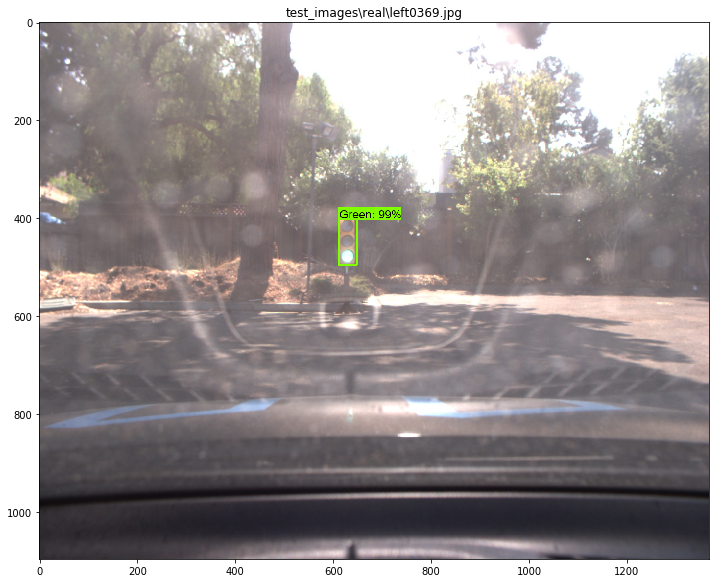

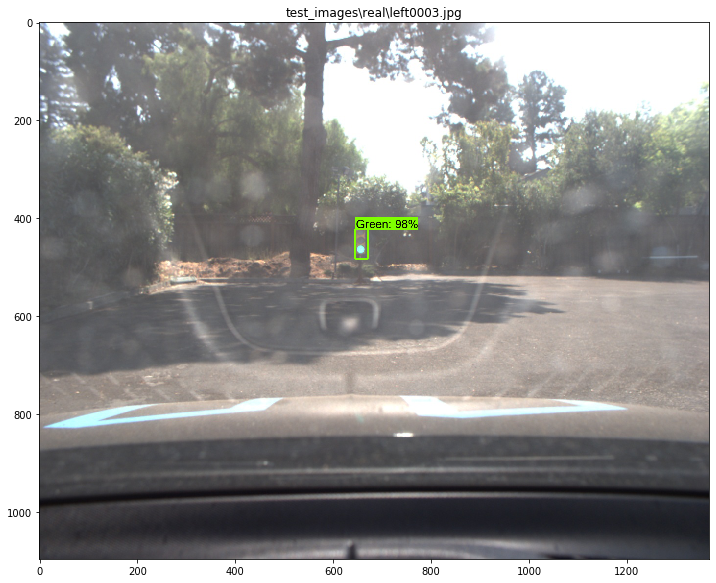

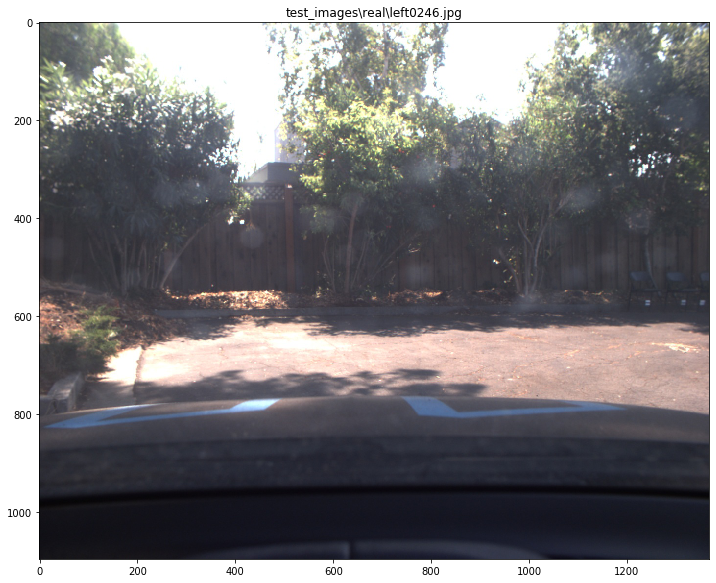

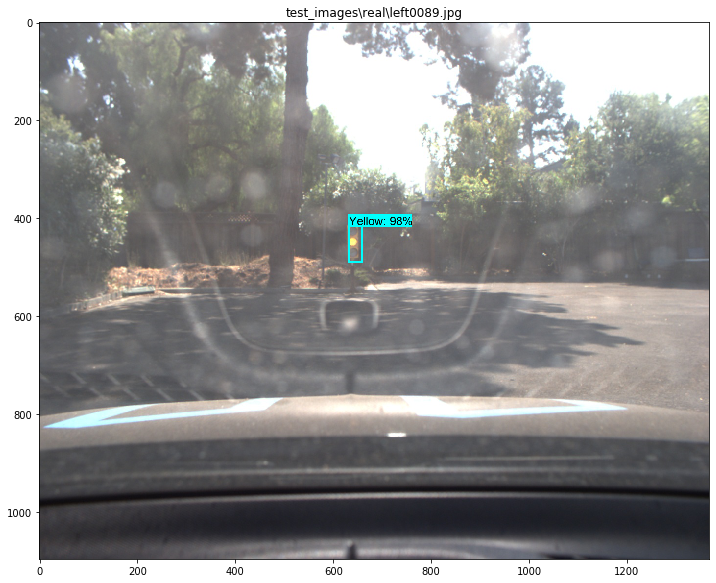

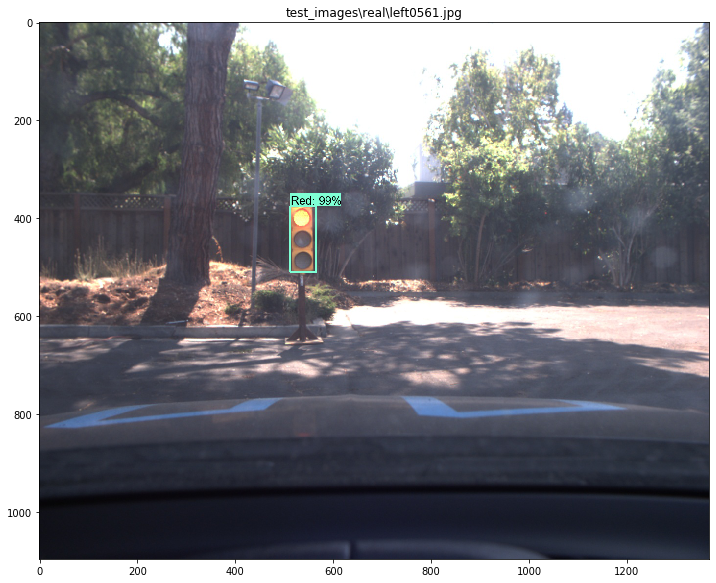

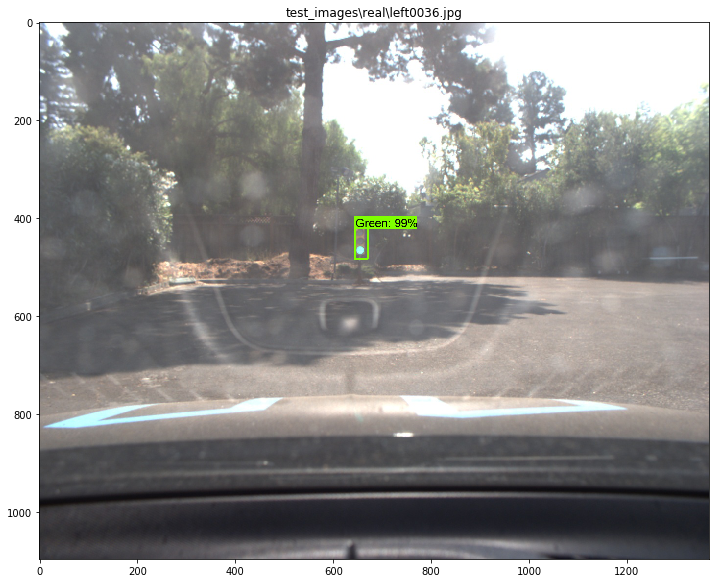

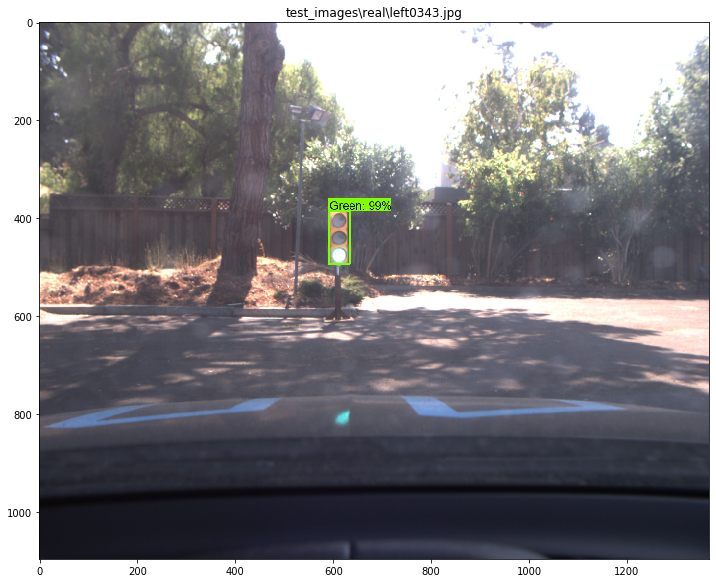

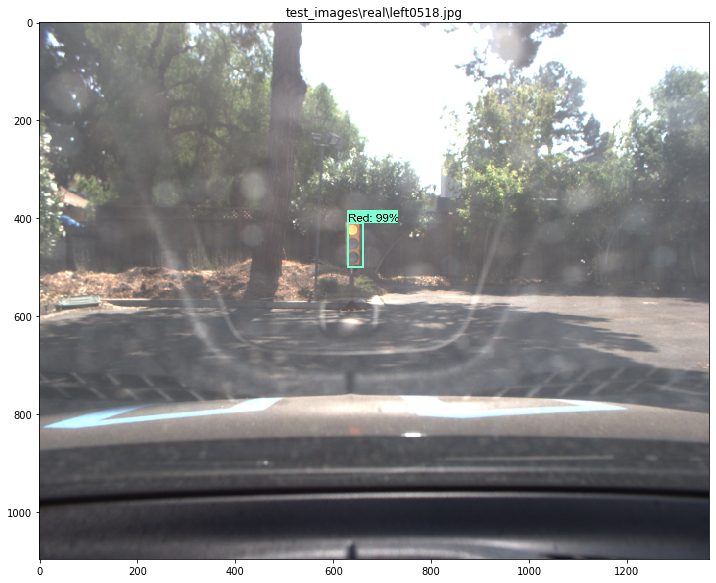

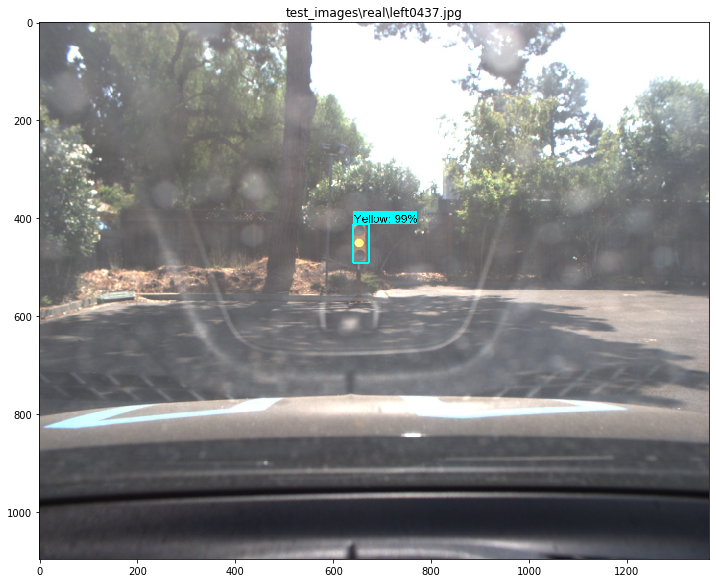

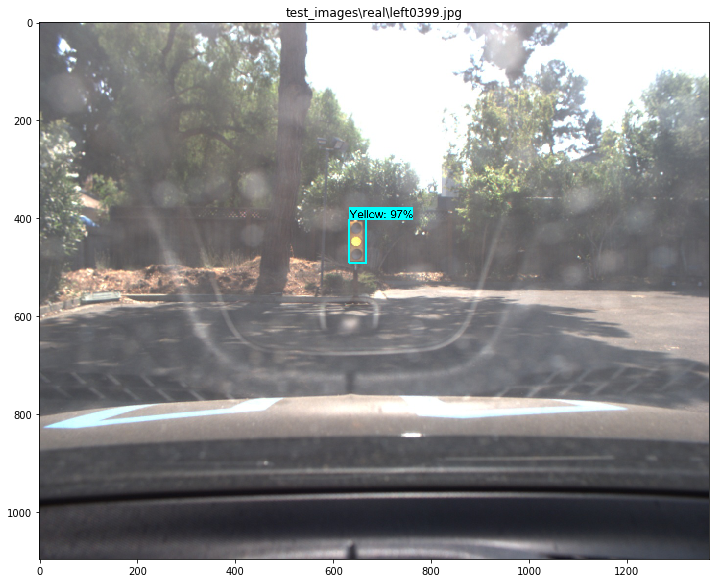

In [30]:
if NUM_SAMPLES > 0:
    test_images = np.random.choice(TEST_IMAGE_PATHS, size = NUM_SAMPLES, replace=False)
else:
    test_images = TEST_IMAGE_PATHS

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in test_images:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=4)
      plt.figure(figsize=IMAGE_SIZE)
      plt.title(image_path)
      plt.imshow(image_np)
      plt.show()